### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Oct  8 02:02:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [3]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 77.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.8/89.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 119.1 MB/s eta 0:00:00


### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [4]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-10-08 02:03:08--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-10-08 02:03:08 (144 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Download dataset from Roboflow Universe

In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="M1OorSRJlYTSNZ9fNQYB")
project = rf.workspace("smartathon").project("new-pothole-detection")
version = project.version(2)
dataset = version.download("yolov12")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to New-pothole-detection-2 in yolov12:: 100%|██████████| 18492/18492 [00:05<00:00, 3621.18it/s]


In [6]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [7]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [8]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['Pothole']

roboflow:
  workspace: smartathon
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [9]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=10)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
New https://pypi.org/project/ultralytics/8.3.206 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/New-pothole-detection-2/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=

100%|██████████| 755k/755k [00:00<00:00, 24.0MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.26M/5.26M [00:00<00:00, 120MB/s]


AMP: checks passed ✅


train: Scanning /content/New-pothole-detection-2/train/labels... 6091 images, 4 backgrounds, 0 corrupt: 100%|██████████| 6091/6091 [00:02<00:00, 2274.63it/s]


train: New cache created: /content/New-pothole-detection-2/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 2171, len(boxes) = 15830. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/New-pothole-detection-2/valid/labels... 2094 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2094/2094 [00:01<00:00, 1350.93it/s]

val: New cache created: /content/New-pothole-detection-2/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      6.73G      3.034       3.73      3.578         20        640: 100%|██████████| 381/381 [03:45<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:34<00:00,  1.89it/s]


                   all       2094       5214     0.0555     0.0905     0.0202     0.0054

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      6.67G      2.608      2.941      2.896         22        640: 100%|██████████| 381/381 [03:19<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.46it/s]


                   all       2094       5214      0.219       0.21      0.119     0.0376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      6.85G      2.412      2.674      2.661         33        640: 100%|██████████| 381/381 [03:17<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.46it/s]


                   all       2094       5214      0.287      0.243      0.169     0.0571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10       6.7G      2.255      2.474        2.5         26        640: 100%|██████████| 381/381 [03:16<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.45it/s]


                   all       2094       5214      0.349      0.306      0.253     0.0911

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      6.83G      2.144      2.295       2.37         33        640: 100%|██████████| 381/381 [03:15<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.48it/s]


                   all       2094       5214      0.456      0.362      0.345      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      6.68G      2.048      2.128      2.258         31        640: 100%|██████████| 381/381 [03:16<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.45it/s]


                   all       2094       5214      0.516      0.397      0.396      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      6.86G      1.981      2.028      2.186         19        640: 100%|██████████| 381/381 [03:16<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:27<00:00,  2.41it/s]


                   all       2094       5214       0.48      0.425      0.407      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      6.84G      1.919      1.917      2.107         37        640: 100%|██████████| 381/381 [03:16<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.46it/s]


                   all       2094       5214      0.576      0.436      0.472      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      6.69G      1.864      1.838      2.058         17        640: 100%|██████████| 381/381 [03:16<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:27<00:00,  2.44it/s]


                   all       2094       5214      0.593      0.479      0.505      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      6.83G      1.827      1.756      2.018         48        640: 100%|██████████| 381/381 [03:16<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:26<00:00,  2.47it/s]


                   all       2094       5214      0.604      0.479       0.52      0.248

10 epochs completed in 0.638 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,074,595 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:28<00:00,  2.29it/s]


                   all       2094       5214      0.605      0.479       0.52      0.248
Speed: 0.2ms preprocess, 8.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train


## Evaluate fine-tuned YOLOv12 model

In [10]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   results.png
confusion_matrix_normalized.png			   train_batch0.jpg
confusion_matrix.png				   train_batch1.jpg
events.out.tfevents.1759889101.6b2a902d1436.276.0  train_batch2.jpg
F1_curve.png					   val_batch0_labels.jpg
labels_correlogram.jpg				   val_batch0_pred.jpg
labels.jpg					   val_batch1_labels.jpg
P_curve.png					   val_batch1_pred.jpg
PR_curve.png					   val_batch2_labels.jpg
R_curve.png					   val_batch2_pred.jpg
results.csv					   weights


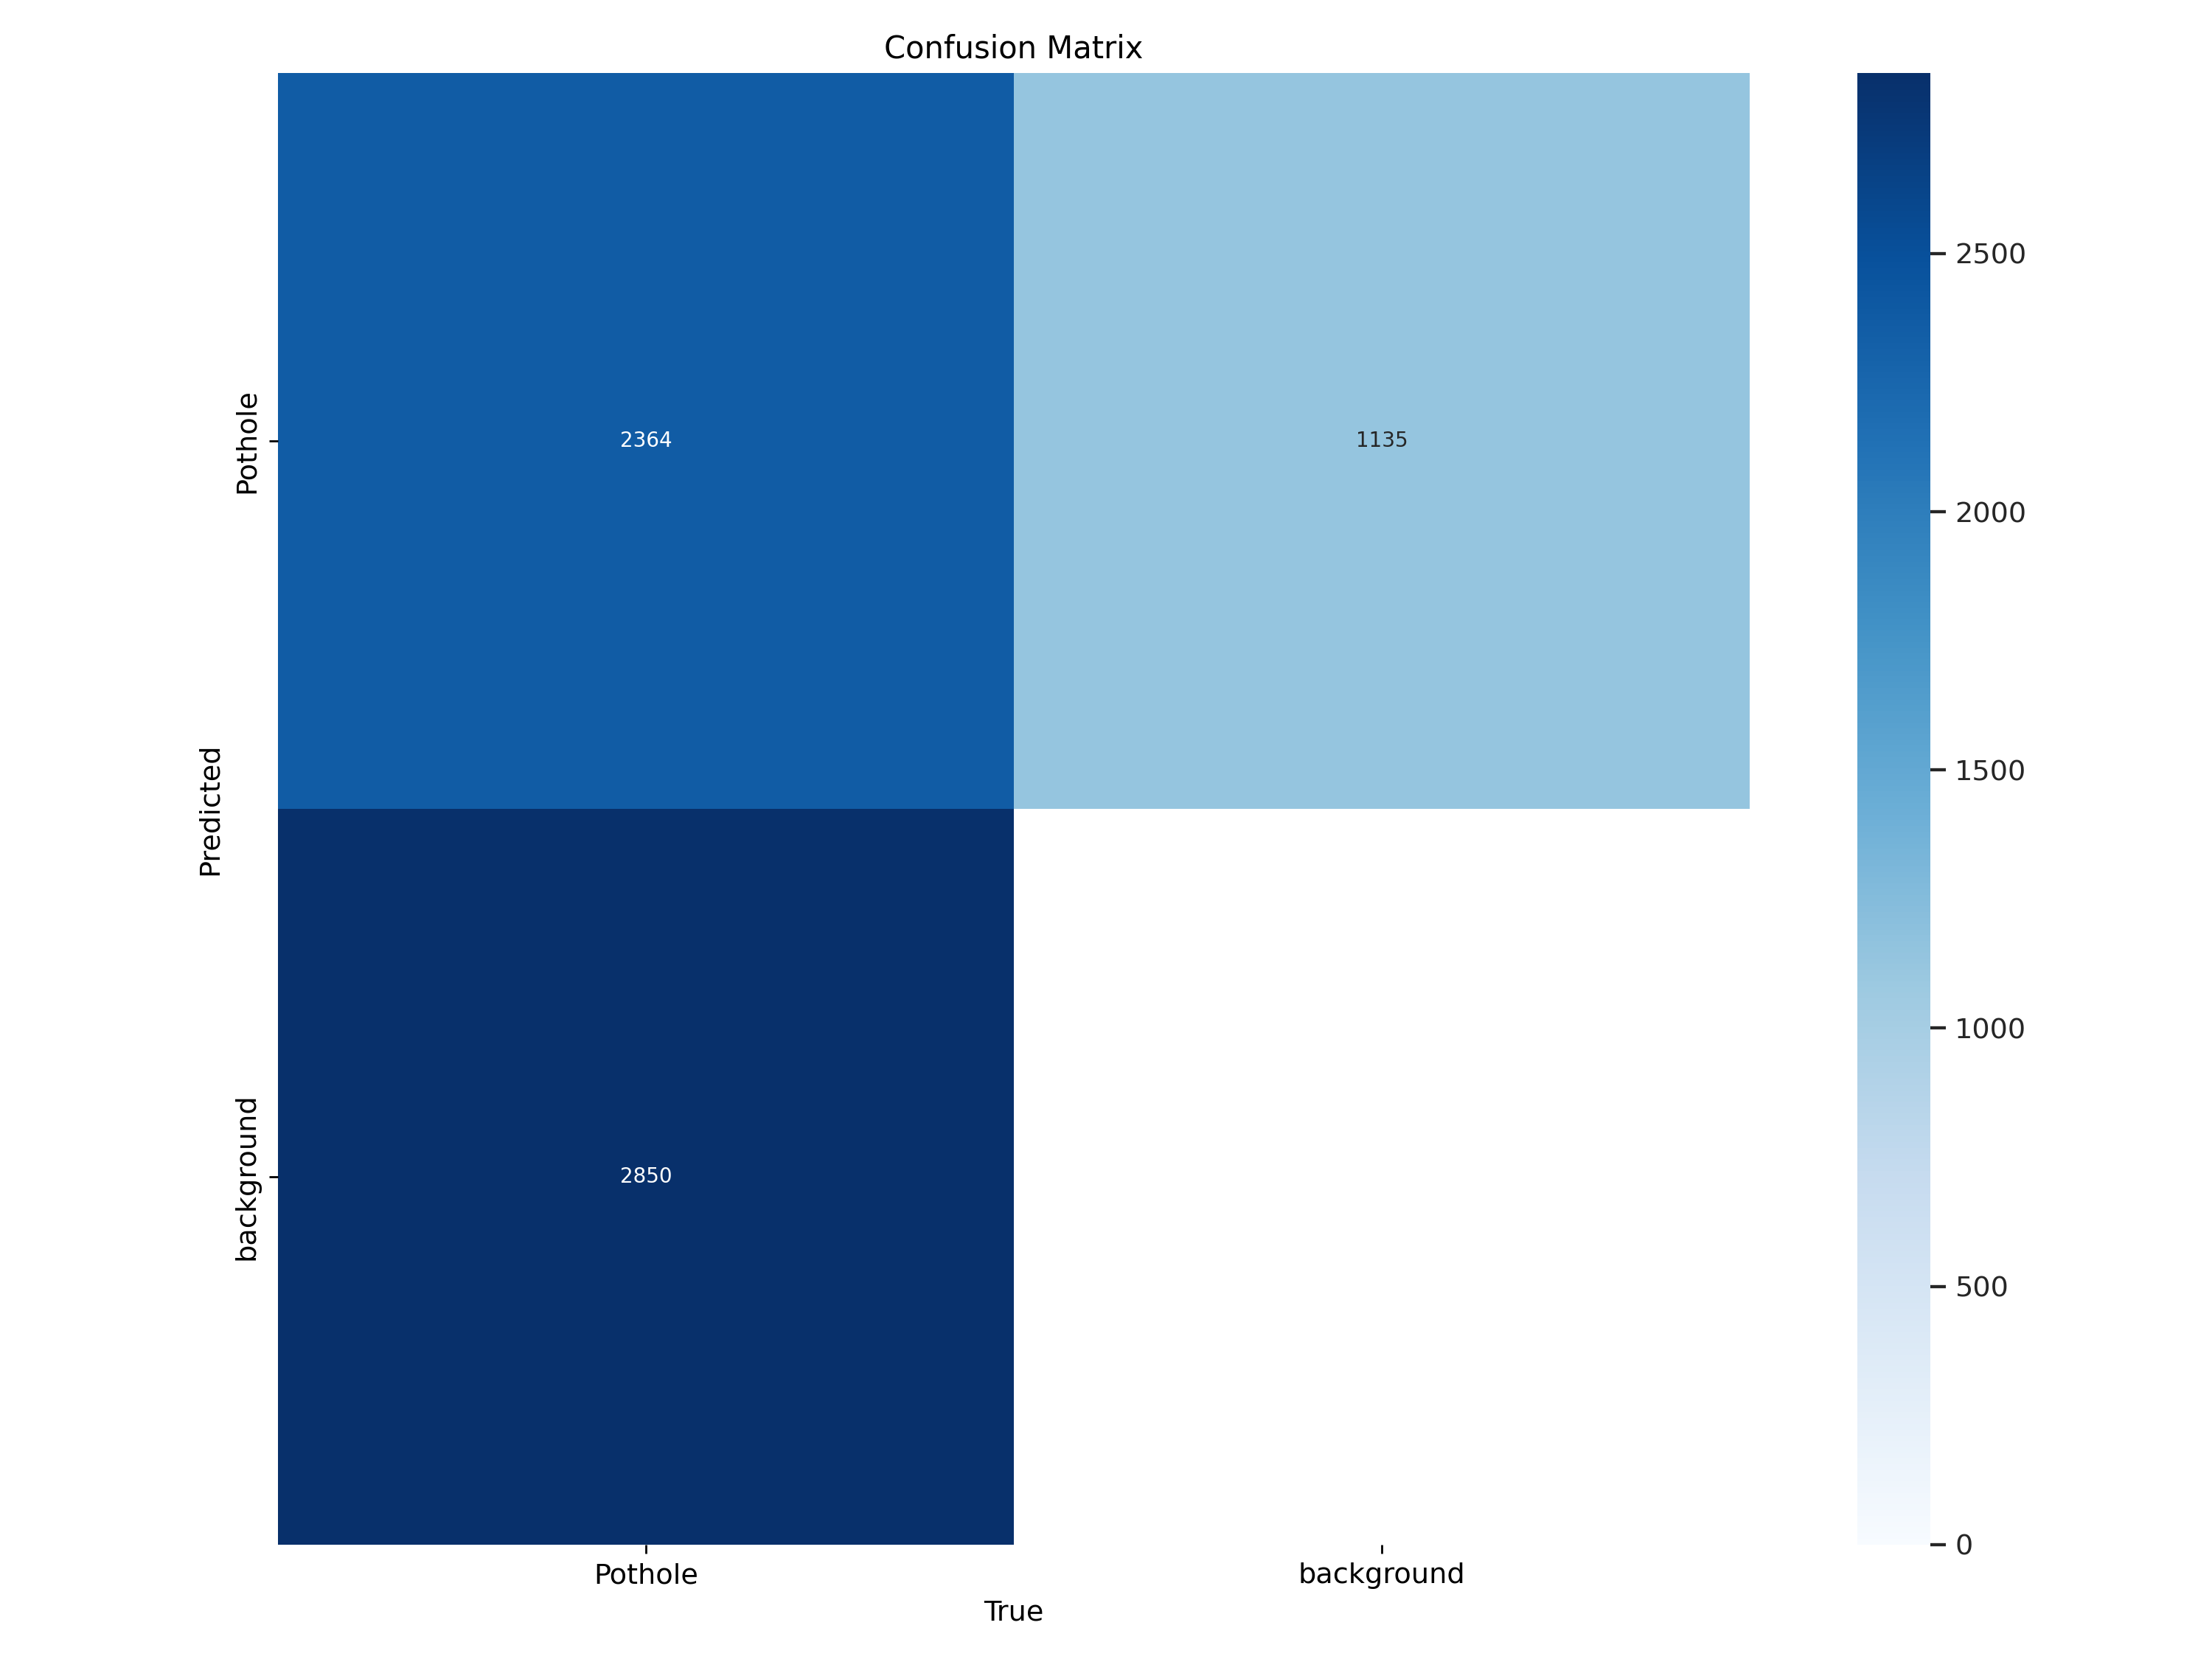

In [11]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

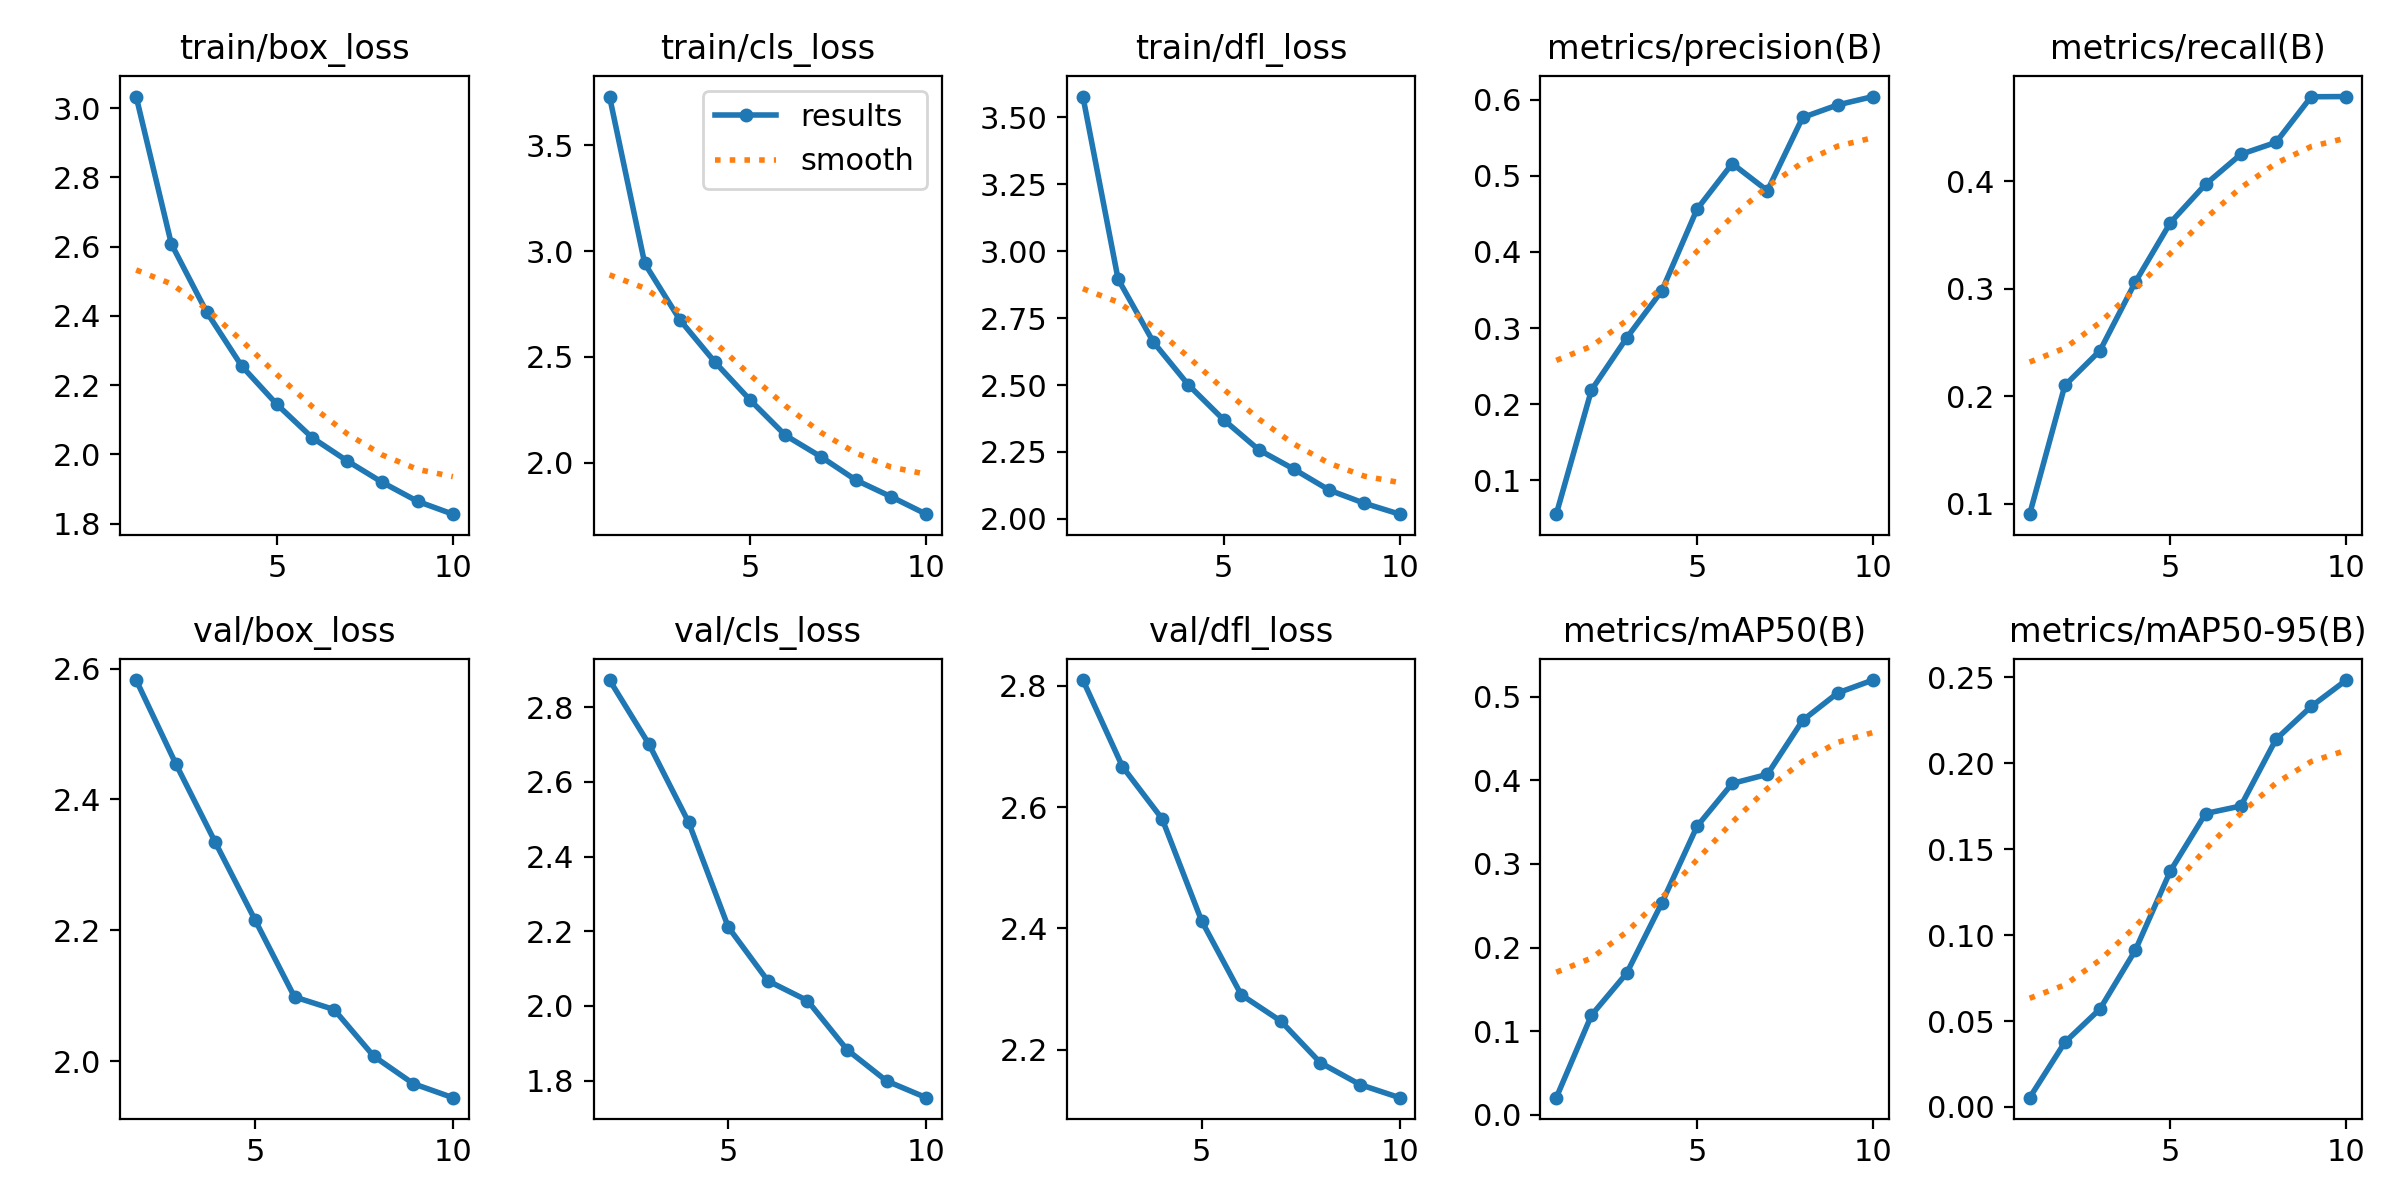

In [12]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [13]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['Pothole']

In [14]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [15]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.22199006049960696
mAP 50 0.42048894844808526
mAP 75 0.21560445800002678


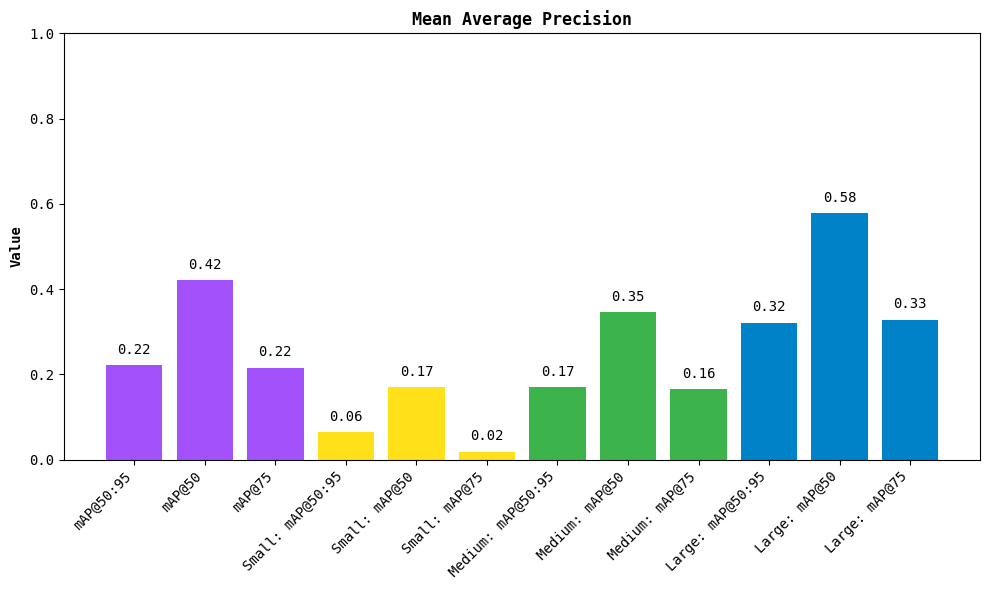

In [16]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [17]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

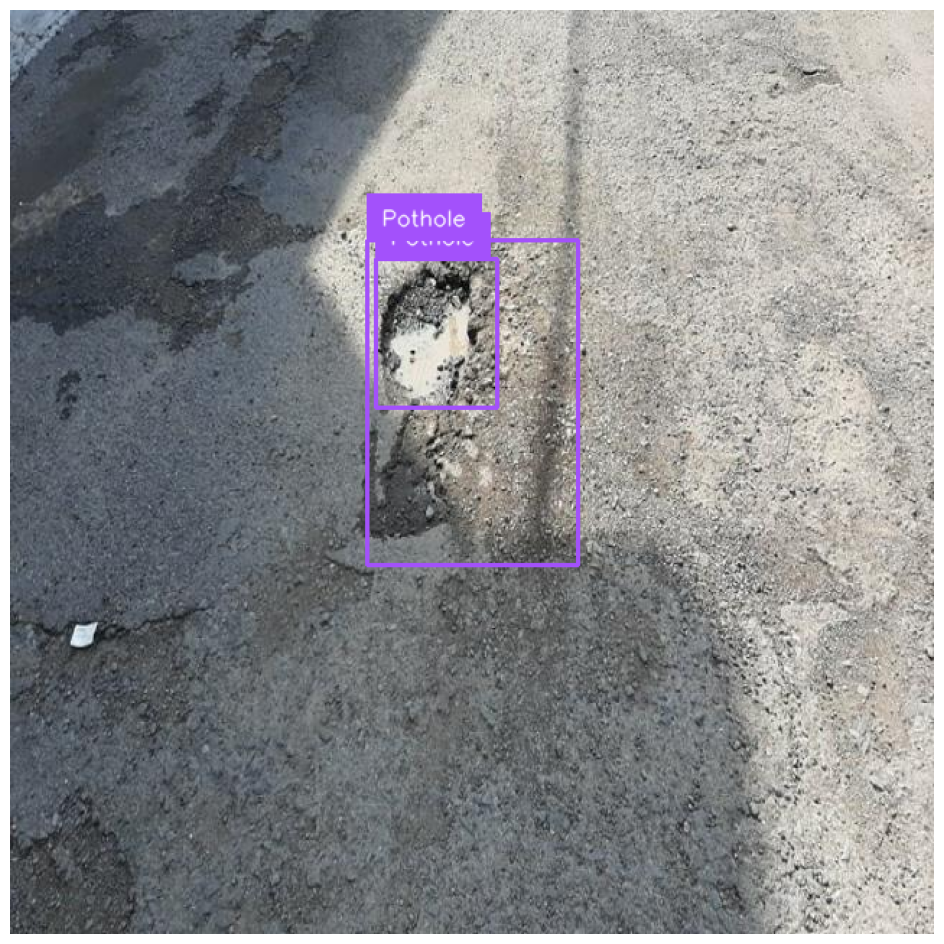

In [23]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)